In [348]:
AMOUNT = 360*26 #360 measurement points per hour * hours
name = 'tum-esm-midcost-raspi-6'

In [349]:
# Imports & Inits

import polars as pl
from datetime import datetime
import asyncpg
import pendulum
import json
import seaborn as sns
import matplotlib.pyplot as plt

data = {
        "integer": [],
        "date": [],
        "system name": [],
        "variant": [],
        "CO2_raw": [],
        "CO2_compensated": [],
        "CO2_filtered": [],
        "sht45_humidity": [],
        "bme280_humidity": [],
        "bme280_pressure": [],
        "sht45_temperature": [],
        "bme280_temperature": [],
        "chamber_temperature": [],
        "gas_bottle_id": []
        }

def plot_sensor_measurement(df, sensor_name):
        df_f = df.filter(pl.col("variant") == "measurement") 
        df_f = df_f.sort("date").filter(pl.col(sensor_name) > 0)
        df_f = df_f.groupby_dynamic("date",every='10m').agg(pl.all().exclude('date').mean())

        sns.lineplot(data=df_f,
                x='date',
                y=sensor_name)


        # set axes labels
        plt.xlabel('Date')
        plt.ylabel(sensor_name)
        plt.xticks(rotation=45)

        # show the plot
        plt.show()

In [350]:
# Database connection
f = open('config.json')
CONFIGURATION = json.load(f)

# Connect to the database
client = await asyncpg.connect(**CONFIGURATION)

# Automatically encode/decode JSONB fields to/from dict
await client.set_type_codec(
    typename="jsonb",
    schema="pg_catalog",
    encoder=json.dumps,
    decoder=json.loads,
)
# Automatically encode/decode UUID fields to/from str
await client.set_type_codec(
    typename="uuid",
    schema="pg_catalog",
    encoder=str,
    decoder=str,
)
# Automatically encode/decode TIMSTAMPTZ fields to/from pendulum.DateTime
await client.set_type_codec(
    typename="timestamptz",
    schema="pg_catalog",
    encoder=lambda x: x.isoformat(),
    decoder=pendulum.parse,
)


def pp(result):
    """Pretty print asynpg query results as JSON strings."""
    for entry in result:
        entry = dict(entry)
        for key, value in entry.items():
            # Print unix timestamps as human-readable dates in Europe/Berlin time zone
            if isinstance(entry[key], pendulum.DateTime):
                entry[key] = entry[key].in_timezone('Europe/Berlin').to_rfc1123_string()
        print(json.dumps(entry, indent=4))

In [351]:
# Receive measurements from the last 26h
result = await client.fetch("""
    SELECT
        sensor.name,
        measurement.creation_timestamp,
        measurement.receipt_timestamp,
        measurement.revision,
        measurement.value
    FROM sensor
    JOIN measurement ON sensor.identifier = measurement.sensor_identifier
    WHERE name = $1
    ORDER BY creation_timestamp DESC
    LIMIT $2
""", name, AMOUNT,)

#pp(result)

In [358]:
# Load data into a dataframe

for n,entry in enumerate(result[::-1]):
        entry = dict(entry)
        #print(entry)
        if entry["value"]["variant"] in ("measurement","calibration"):
                data["integer"].append(n)
                data["date"].append(entry["creation_timestamp"])
                data["system name"].append(entry["name"])
                data["variant"].append(entry["value"]["variant"])
                data["CO2_raw"].append(entry["value"]["data"]["raw"])
                data["CO2_compensated"].append(entry["value"]["data"]["compensated"])
                data["CO2_filtered"].append(entry["value"]["data"]["compensated"])
                data["sht45_humidity"].append(entry["value"]["data"]["sht45_humidity"])
                data["bme280_humidity"].append(entry["value"]["data"]["bme280_humidity"])
                data["bme280_pressure"].append(entry["value"]["data"]["bme280_pressure"])
                data["sht45_temperature"].append(entry["value"]["data"]["sht45_temperature"])
                data["bme280_temperature"].append(entry["value"]["data"]["bme280_temperature"])
                data["chamber_temperature"].append(entry["value"]["data"]["chamber_temperature"])
                
                if entry["value"]["variant"] == "calibration":
                        data["gas_bottle_id"].append(entry["value"]["data"]["gas_bottle_id"])
                else:
                        data["gas_bottle_id"].append(None)
     
df = pl.DataFrame(data)
df.head()
        

integer,date,system name,variant,CO2_raw,CO2_compensated,CO2_filtered,sht45_humidity,bme280_humidity,bme280_pressure,sht45_temperature,bme280_temperature,chamber_temperature,gas_bottle_id
i64,datetime[μs],str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
0,2023-07-06 11:43:13.570,"""tum-esm-midcos…","""measurement""",360.7,398.0,398.0,33.35,34.22,942.18,29.77,29.65,31.0,null
1,2023-07-06 11:43:23.570,"""tum-esm-midcos…","""measurement""",357.6,401.3,401.3,33.34,34.19,943.76,29.76,29.65,31.1,null
2,2023-07-06 11:43:33.560,"""tum-esm-midcos…","""measurement""",355.8,398.9,398.9,33.31,34.16,945.93,29.75,29.65,31.0,null
3,2023-07-06 11:43:43.520,"""tum-esm-midcos…","""measurement""",359.9,399.5,399.5,33.3,34.14,947.43,29.76,29.66,31.1,null
4,2023-07-06 11:43:53.530,"""tum-esm-midcos…","""measurement""",356.4,397.1,397.1,33.3,34.13,942.7,29.76,29.65,31.0,null


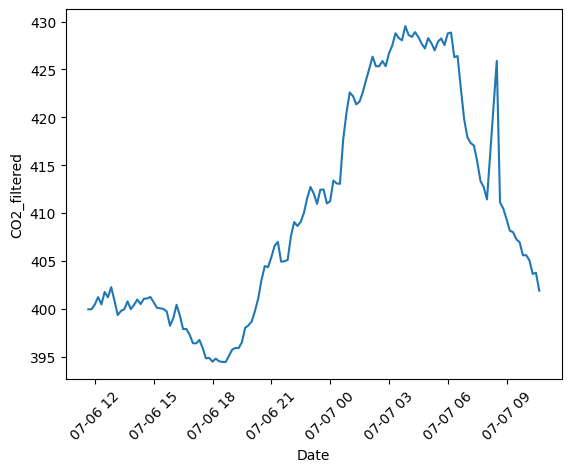

In [353]:
# Plot CO2_Filtered

df_f = df.filter(pl.col("variant") == "measurement") 
df_f = df_f.sort("date").filter(pl.col("CO2_filtered") > 0)
df_f = df_f.groupby_dynamic("date",every='10m').agg(pl.all().exclude('date').mean())

sns.lineplot(data=df_f,
        x='date',
        y='CO2_filtered')


# set axes labels
plt.xlabel('Date')
plt.ylabel('CO2_filtered')
plt.xticks(rotation=45)

# show the plot
plt.show()

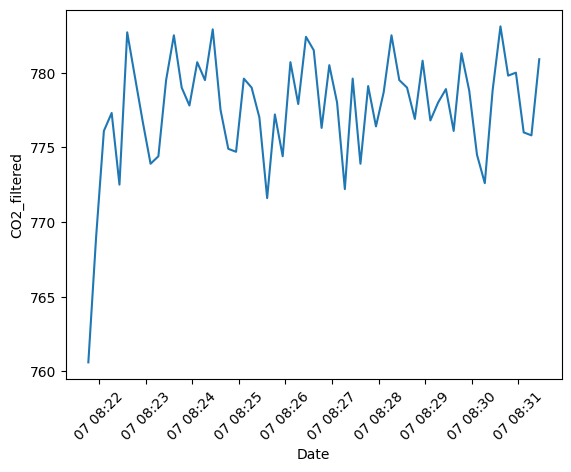

In [354]:
# Plot 800ppm Calibration Bottle 

df_f = df.filter(pl.col("variant") == "calibration") 
df_f = df_f.sort("date").filter(pl.col("CO2_filtered") > 750)
#df_f = df_f.groupby_dynamic("date",every='1h').agg(pl.all().exclude('date').mean())

sns.lineplot(data=df_f,
        x='date',
        y='CO2_filtered')


# set axes labels
plt.xlabel('Date')
plt.ylabel('CO2_filtered')
plt.xticks(rotation=45)

# show the plot
plt.show()

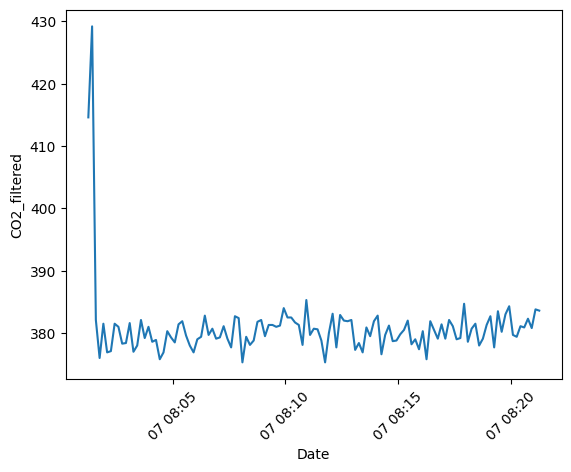

In [357]:
# Plot 400ppm Calibration Bottle 
df_f = df.filter(pl.col("variant") == "calibration") 
df_f = df_f.sort("date").filter(pl.col("CO2_filtered") < 450)
#df_f = df_f.groupby_dynamic("date",every='1h').agg(pl.all().exclude('date').mean())

sns.lineplot(data=df_f,
        x='date',
        y='CO2_filtered')


# set axes labels
plt.xlabel('Date')
plt.ylabel('CO2_filtered')
plt.xticks(rotation=45)

# show the plot
plt.show()

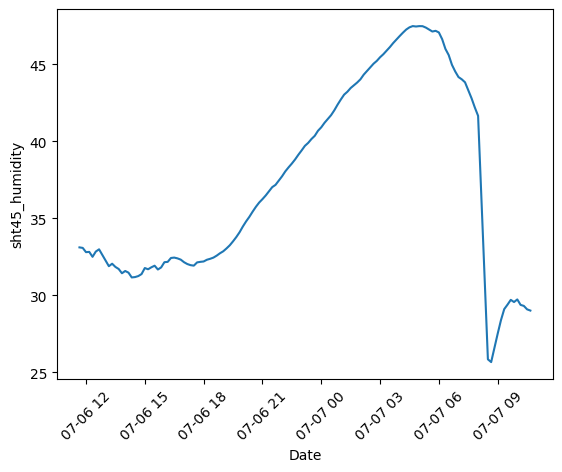

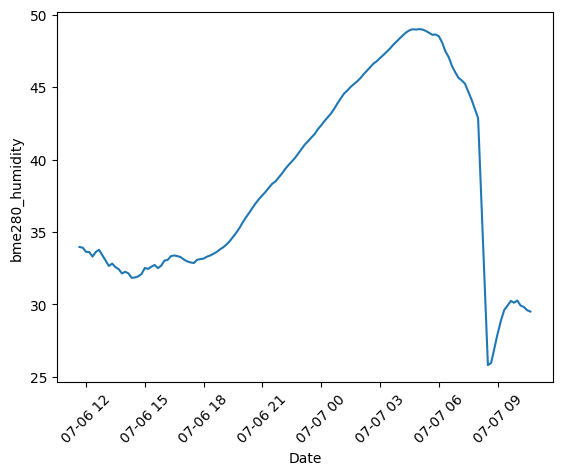

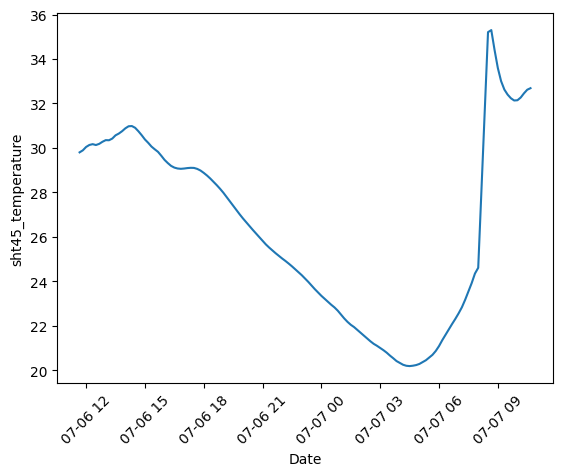

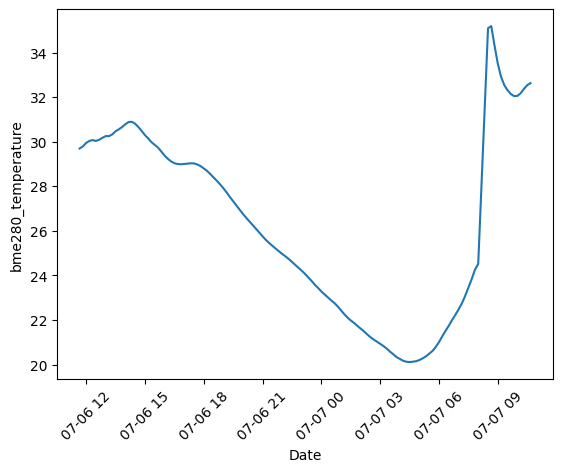

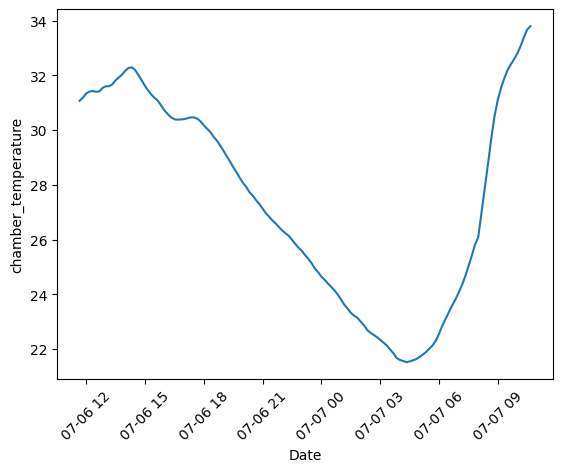

In [356]:
# Plot auxilliary data
plot_sensor_measurement(df, "sht45_humidity")
plot_sensor_measurement(df, "bme280_humidity")
plot_sensor_measurement(df, "sht45_temperature")
plot_sensor_measurement(df, "bme280_temperature")
plot_sensor_measurement(df, "chamber_temperature")
